In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred

# Replace 'YOUR_API_KEY' with your actual FRED API key
api_key = '230970faf44ea208229d77dff9f995f3'
fred = Fred(api_key=api_key)

# Define the series IDs
series_ids = {
    

    'NASDAQ': 'NASDAQCOM',
    '10YR_Treasury_Yield': 'GS10',
    'Real_GDP': 'GDPC1',#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 27 19:57:44 2023

@author: williamarnaud
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Oct 27 17:37:06 2023
 
@author: S084339
"""
 
"""
https://www.kaggle.com/code/eneszvo/time-series-forecasting-es-arima-var
Vector Autoregression Model (VAR)
Similar to the AR model but using multiple time series. As opposite to previous models which are utilizing univariate time series, where the signal has only a single time-dependent variable, the VAR model using multivariate time series. Basically, it means that each signal depends not only on its past but also on the previous values of some other signals. The simplest model VAR(1) with two time series  
yt and xt can be written as
 
yt = a1 + b11 yt-1 + b12 xt-1 + eyt
xt = a2 + b21 yt-1 + b22 xt-1 + ext
 
where a and b are coefficients, and e is error.
 
VAR model requires stationarity of signals. However, when signals xt and yt are I(1) (non-stationary with the order of integration 1)
and if there is a o such that (yt - o xt) is stationary, xt and yt are cointegrated and a VEC model can be used.
 
Cointegration can be tested using augmented Engle-Granger cointegration test
where the null hypothesis assumes that there is no cointegration.
It means that if the p-value is less than 0.05, then we can reject a null hypothesis and say that signals are cointegrated.
 
"""

# CE SITE !!
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
 
 
 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import numpy as np
import os
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse
from fredapi import Fred
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import yfinance as yf
 
 
def get_FRED_series(ticker):
    FRED_API_KEY = "cc8c5ce8b5f37ae0255d927b30d50982"
    fred = Fred(api_key=FRED_API_KEY)
    data = fred.get_series(ticker)
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index, utc=True)
    return data
 
def get_yahoo_series(ticker):
    data = yf.Ticker(ticker).history(period='max')["Close"]
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index, utc=True)
    return data

x = get_yahoo_series('GOOG')

def ADF_reg_detail(series):
    """
   Parameters
    ----------
    series : TYPE
        DESCRIPTION.
 
    Returns
    -------
    None.
   
    Rappel
    -------
    Dans les regs : x1 c'est le Rho, const le coef, x2 le coef trend!
    p-value : ProbabilitÃ© de H0, si p-value <0.05 rejeter H0, sinon H0 ok
 
    """
    reg = adfuller(series, regression='ct', regresults=True, store=True)
    rho_coef = reg[3].resols.params[0]
    rho_pv = reg[3].resols.pvalues[0]
    cst_coef = reg[3].resols.params[1]
    cst_pv = reg[3].resols.pvalues[1]
    trend_coef = reg[3].resols.params[2]
    trend_pv = reg[3].resols.pvalues[2]
    print('====================')
    print('Regression CT : ')
    print('====================')
    print('Rho coef :', rho_coef)
    print('Rho p-value :', rho_pv)
    print('Constant coef :', cst_coef)
    print('Constant p-value :', cst_pv)
    print('Trend coef :', cst_coef)
    print('Trend p-value :', cst_pv)
    print("")
    print("--------------------")
    if trend_pv < 0.05 :
        print('Strong evidence against the null hypothesis (Trend coefficient =0 )')
        print('Reject the null hypothesis')
        print('The series has a trend')
        if rho_pv <0.05 :
            print("rho diff 0, the series has no UR, but a deterministic trend")
        else :
            print("rho=0, the series has a UR, and has a deterministic trend")
        return
    if trend_pv > 0.05 :
        print('Weak evidence against the null hypothesis (Trend coefficient =0 )')
        print('Fail to reject the null hypothesis')
        print('The series has no trend')
    print("")
    print("")
    reg = adfuller(series, regression='c', regresults=True, store=True)
    rho_coef = reg[3].resols.params[0]
    rho_pv = reg[3].resols.pvalues[0]
    cst_coef = reg[3].resols.params[1]
    cst_pv = reg[3].resols.pvalues[1]
    print('====================')
    print('Regression C : ')
    print('====================')
    print('Rho coef :', rho_coef)
    print('Rho p-value :', rho_pv)
    print('Constant coef :', cst_coef)
    print('Constant p-value :', cst_pv)
    print("")
    print("--------------------")
    if cst_pv < 0.05 :
        print('Strong evidence against the null hypothesis (constant coefficient = 0)')
        print('Reject the null hypothesis')
        print('The series has a constant')
        if rho_pv < 0.05 :
            print("rho diff 0, the series has no UR, but a constant and no trend.")
        else :
            print("rho=0, the series has a UR, and has a constant, but no trend")
        return
    if cst_pv > 0.05 :
        print('Weak evidence against the null hypothesis (constant coefficient =0)')
        print('Fail to reject the null hypothesis')
        print('The series has no constant')
    print("")
    print("")
    reg = adfuller(series, regression='n', regresults=True, store=True)
    rho_coef = reg[3].resols.params[0]
    rho_pv = reg[3].resols.pvalues[0]
    print('====================')
    print('Regression NC : ')
    print('====================')
    print('Rho coef :', rho_coef)
    print('Rho p-value :', rho_pv)
    print("")
    print("--------------------")
    if rho_pv < 0.05 :
        print('Strong evidence against the null hypothesis (UR coefficient = 0)')
        print('Reject the null hypothesis')
        print('The series is stationary, no UR, without a constant, nor trend.')
    if rho_pv > 0.05 :
        print('Weak evidence against the null hypothesis (UR coefficient =0)')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')
    print("")
    print("")
 
 
 
def johansen_coint_test(df):
    """
    Eigenvalues: In the Johansen cointegration test, the eigenvalues represent the characteristic roots of a matrix formed during the test.
    These eigenvalues provide valuable information about the cointegration structure of the time series.
   
    Sorting Eigenvalues: The eigenvalues are typically sorted in descending order, which means the largest eigenvalue is listed first.
   
    Comparing Eigenvalues to Critical Values: To determine the number of cointegrating relationships, you need to compare the eigenvalues to critical
    values from statistical tables or generated using Monte Carlo simulations.
    These critical values depend on the sample size, significance level, and the number of time series.
   
    Interpretation based on Eigenvalues and Critical Values:        H0 : r=0, H1: r=1
 
        * Case 1: If all eigenvalues are less than the critical values, this suggests that there are no cointegrating relationships.
        In other words, the time series are not cointegrated.
        * Case 2: If at least one eigenvalue exceeds the critical values, it suggests the presence of cointegration.
            - If only one eigenvalue exceeds the critical values, it indicates the existence of a single cointegrating relationship.
            - If multiple eigenvalues exceed the critical values, you'll need to examine the pattern of eigenvalues.
            The number of eigenvalues that exceed the critical values determines the rank of cointegration.
                - If all but one eigenvalue exceeds the critical values, there is one cointegrating relationship.
                - If all but two eigenvalues exceed the critical values, there are two cointegrating relationships.
                - And so on...
        * Case 3: If all eigenvalues exceed the critical values, it suggests that all variables are cointegrated, but the test may not be able to identify the exact number of cointegrating relationships.
   
    """
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    print("===================================================")
    print("Trace Statistic:")
    print("--------------------------------------------------")
    print(result.trace_stat)  # Trace statistic
    print("\nCritical Values at 90%-95%-99% Confidence Level:")
    print("--------------------------------------------------")
    print(result.trace_stat_crit_vals)  # Critical values
    print("===================================================")
    print("\nEigenvalues:")
    print("--------------------------------------------------")
    print(result.eig)  # Eigenvalue
    print("\n Max Eigenvalues Statistic:")
    print("--------------------------------------------------")
    print(result.max_eig_stat)  # Eigenvalue
    print("\nCritical Values at 90%-95%-99% Confidence Level:")
    print("--------------------------------------------------")
    print(result.max_eig_stat_crit_vals)  # Critical values
    print("===================================================")
 
 
 
def select_VAR_order(df, nb_orders_tested=50):
    l = []
    for p in range(nb_orders_tested):
        model = VAR(df)
        results = model.fit(p)
        l.append((p, results.aic, results.bic))
    l = pd.DataFrame(l)
    l.columns = ["p", "AIC", "BIC"]
    l = l.sort_values(by="AIC",ascending=True)
    print(l[:5])
    print("==================================")
    l = l.sort_values(by="BIC",ascending=True)
    print(l[:5])
 
 
 
def predict_VAR(df, nb_order=10, prop_train=0.9):
        train = df[:round(prop_train*len(df))]
        test = df[round((prop_train)*len(df)):]
        model = VAR(df)
        results = model.fit(nb_order)
        print(results.summary())
        lag_order = results.k_ar
        forecast = results.forecast(y=train.values[-lag_order:],steps = round((1-prop_train)*len(df)))
        df_forecast = pd.DataFrame(forecast, index=test.index, columns=['SPY_forecast', 'IR10_forecast', 'IR3_forecast'])
        alls = df.merge(df_forecast, how='left', left_index=True, right_index=True)
       
        plt.figure(1)
        alls[["SPY","SPY_forecast"]].plot()
        plt.figure(1)
        alls[["IR10", "IR10_forecast"]].plot()
        plt.figure(3)
        alls[["IR3", "IR3_forecast"]].plot()
       
        #model evaluation :
        RMSE1 = rmse(alls.dropna()["SPY"], alls.dropna()["SPY_forecast"] )
        print("RMSE for SPY is :", RMSE1)
        RMSE2 = rmse(alls.dropna()["IR10"], alls.dropna()["IR10_forecast"] )
        print("RMSE for IR10 is :", RMSE2)
        RMSE3 = rmse(alls.dropna()["IR3"], alls.dropna()["IR3_forecast"] )
        print("RMSE for IR3 is :", RMSE3)
 
 
def grangers_causation_matrix(data, test='ssr_chi2test', verbose=False, maxlag=30):   
    
    """
    H0 : the coefficient of the corresponding causation is 0; That is the X does not cause Y.
    If P-values in the table < significance level (0.05) --> H0 can be rejected .
    """
    variables = data.columns
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df 
 


#%%
 
 
# SP500 (daily close)
series_SPY =  np.log(get_FRED_series('SP500')["2013":"2023"])
 
#Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10)
series_ir10 = np.log(get_FRED_series('DGS10')["2013":"2023"])
 
#3-Month Treasury Bill Secondary Market Rate
series_ir3 = np.log(get_FRED_series('DTB3')["2013":"2023"].resample('D').interpolate(method='linear'))

series3 = np.log(get_FRED_series('GEPUCURRENT')["2013":"2023"].resample('D').interpolate(method='linear'))

series4 = np.log(get_FRED_series('T5YIE')["2013":"2023"].resample('D').interpolate(method='linear'))

series5 = np.log(get_FRED_series('OVXCLS')["2013":"2023"].resample('D').interpolate(method='linear'))

series6 = np.log(get_FRED_series('MEDCPIM158SFRBCLE')["2013":"2023"].resample('D').interpolate(method='linear'))

series7 = np.log(get_yahoo_series('META')["2013":"2023"])

series8 = np.log(get_yahoo_series('GOOG')["2013":"2023"])

series9 = np.log(get_yahoo_series('INFL.SW')["2013":"2023"])

series10 = np.log(get_yahoo_series('TSLA')["2013":"2023"])




merged = pd.concat([series7, series8, series10], axis=1)
merged = merged["2020":]
merged = merged.replace([np.inf, -np.inf], np.nan)
merged = merged.apply(lambda x: x.fillna(x.mean()), axis=1)
merged.columns = ['1', '2', "4"]
merged.plot()

johansen_coint_test(merged)


for i in range(len(merged.columns)):
    print(ADF_reg_detail(merged.iloc[:,i]))


johansen_coint_test(merged)

grangers_causation_matrix(merged)






    'Exports': 'EXJPUS',
    'VIX': 'VIXCLS',
}

# Define the observation period
start_date = '2000-01-01'
end_date = '2022-12-31'

# Download the data
data = {}
for series_name, series_id in series_ids.items():
    data[series_name] = fred.get_series(series_id, start_date, end_date, frequency='q')

# Transform the series (log)
for series_name, series_data in data.items():
    data[series_name] = pd.Series(data[series_name]).apply(lambda x: pd.np.log(x))

# Create a DataFrame from the log-transformed data
df = pd.DataFrame(data)

C:\Users\zgcha\AppData\Local\Temp\ipykernel_16940\1152254280.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data[series_name] = pd.Series(data[series_name]).apply(lambda x: pd.np.log(x))


In [78]:
import itertools

# Get all possible combinations of the series names
combinations = list(itertools.combinations(df.columns, 2))

# Create a list to store the results
cointegration_results = []

# Perform Johansen cointegration test for each combination
for series1, series2 in combinations:
    # Perform Johansen cointegration test
    coint_result = sm.tsa.coint(df[series1], df[series2])
    
    # Store the combination and test results
    cointegration_results.append({
        'Combination': (series1, series2),
        'p-value': coint_result[1],
        't-stat': coint_result[0],
        'threshold': coint_result[2]
    })

# Convert the results to a DataFrame
cointegration_results_df = pd.DataFrame(cointegration_results)

# Display or analyze the results as needed
print(cointegration_results_df)

# Print co-integrated series
co_integrated_series = cointegration_results_df[cointegration_results_df['p-value'] < 0.05]
print('Here are the co-integrated Series:')
print(co_integrated_series['Combination'].tolist())


                       Combination   p-value    t-stat  \
0    (NASDAQ, 10YR_Treasury_Yield)  0.697805 -1.653466   
1               (NASDAQ, Real_GDP)  0.000821 -4.604207   
2                (NASDAQ, Exports)  0.912687 -0.945610   
3                    (NASDAQ, VIX)  0.935785 -0.791703   
4  (10YR_Treasury_Yield, Real_GDP)  0.007829 -3.973572   
5   (10YR_Treasury_Yield, Exports)  0.456775 -2.137525   
6       (10YR_Treasury_Yield, VIX)  0.460594 -2.130201   
7              (Real_GDP, Exports)  0.952866 -0.638621   
8                  (Real_GDP, VIX)  0.988547  0.132497   
9                   (Exports, VIX)  0.615408 -1.829251   

                                           threshold  
0  [-4.020839215070644, -3.4040978903514065, -3.0...  
1  [-4.020839215070644, -3.4040978903514065, -3.0...  
2  [-4.020839215070644, -3.4040978903514065, -3.0...  
3  [-4.020839215070644, -3.4040978903514065, -3.0...  
4  [-4.020839215070644, -3.4040978903514065, -3.0...  
5  [-4.020839215070644, -3.4040

<B> Plot ('NASDAQ', 'Real_GDP')

<AxesSubplot:>

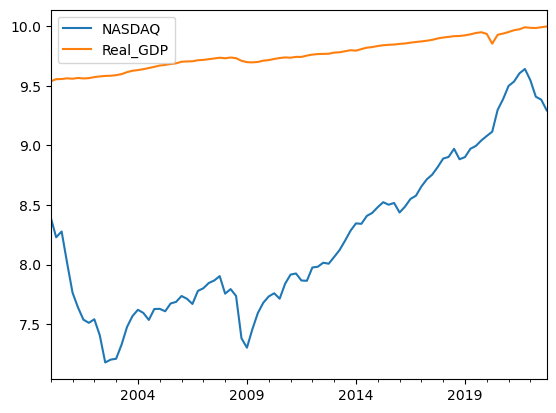

In [79]:
df[['NASDAQ', 'Real_GDP']].plot()

 <b>Plot '10YR_Treasury_Yield', 'Real_GDP'

<AxesSubplot:>

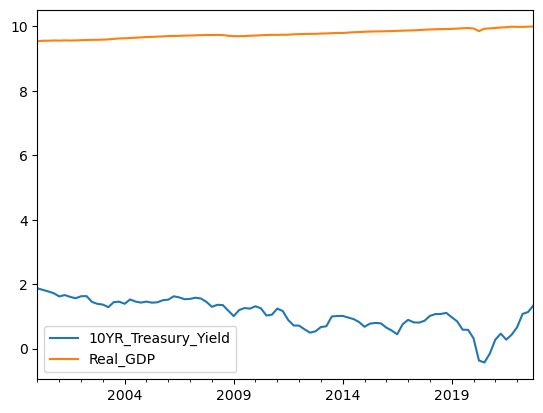

In [80]:
df[['10YR_Treasury_Yield', 'Real_GDP']].plot()

Pair 1: ('NASDAQ', 'Real_GDP')
1. VAR Model with First Differences:
Choose an appropriate lag order for your VAR model.
Estimate the VAR model using the first differences of the I(1) variables ('NASDAQ' and 'Real_GDP').
Conduct causality tests to understand the relationships between these variables in first differences.
2. VECM (Vector Error Correction Model):
Determine the order of the VAR model in levels (before differencing) using AIC or BIC criteria.
Estimate the VECM using the identified VAR lag order.
Perform causality tests to investigate both long-term and short-term causal relationships between 'NASDAQ' and 'Real_GDP'.
Validate the error-correction mechanisms if they exist.

In [96]:
# Make a copy of the DataFrame to work with
df_copy = df.copy()
df_copy = df_copy[['NASDAQ', 'Real_GDP']].pct_change().dropna()
# Choose an appropriate lag order for your VAR model using AIC or BIC criteria
from statsmodels.tsa.api import VAR

# Identify the optimal lag order
model = VAR(df_copy)
lag_order = model.select_order(maxlags=10)
optimal_lag = lag_order.selected_orders['aic']

# Estimate the VAR model with the optimal lag order using first differences
var_model_diff = VAR(df_copy).fit(optimal_lag)
print("Optimal Lag Order:", optimal_lag)

# Conduct Granger causality tests to understand the relationships between variables in first differences
granger_causality = var_model_diff.test_causality(caused='Real_GDP', causing='NASDAQ', kind='f')
print(granger_causality.summary())


Optimal Lag Order: 1
Granger causality F-test. H_0: NASDAQ does not Granger-cause Real_GDP. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.775          3.895   0.030 (1, 174)
----------------------------------------------


C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [97]:
# Print VAR model summary to examine coefficients and statistics
print(var_model_diff.summary())

# Assess the goodness of fit
# You can check for serial correlation, heteroskedasticity, and other diagnostic tests.
# For example, you can use the Durbin-Watson test for serial correlation.
from statsmodels.stats.stattools import durbin_watson
durbin_watson_stat = durbin_watson(var_model_diff.resid)
print("Durbin-Watson Statistic:", durbin_watson_stat)

# Draw conclusions about the relationships between 'NASDAQ' and 'Real_GDP'
# Analyze coefficient signs and significance to interpret the relationships.
# For example, if a coefficient is positive and significant, it suggests a positive relationship.

# Visualize the results if needed, e.g., plot impulse response functions.

# Summarize your findings and draw conclusions based on the analysis.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Nov, 2023
Time:                     20:28:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.2018
Nobs:                     90.0000    HQIC:                  -22.3013
Log likelihood:           757.174    FPE:                1.92977e-10
AIC:                     -22.3685    Det(Omega_mle):     1.80727e-10
--------------------------------------------------------------------
Results for equation NASDAQ
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001362         0.001205            1.130           0.258
L1.NASDAQ           0.410495         0.101055            4.062           0.000
L1.Real_GDP        -0.923254         0.869746           -1.062     

## Interpretation of the VAR model results
Examine the coefficients, their significance, and the lag order.

Example interpretation:
If the coefficient for 'NASDAQ' in the 'Real_GDP' equation is positive and significant,
it suggests that changes in the NASDAQ index Granger cause changes in Real GDP.

If the coefficient for 'Real_GDP' in the 'NASDAQ' equation is positive and significant,
it suggests that changes in Real GDP Granger cause changes in the NASDAQ index.

If both coefficients are significant, it indicates a bi-directional relationship.

Assess the direction and magnitude of the relationship based on the coefficients.

Summarize your findings and economic implications.

You can also perform additional analyses or conduct hypothesis tests to validate the relationships.

End the analysis with a clear conclusion based on the results and their economic interpretation.


2. VECM (Vector Error Correction Model):
Determine the order of the VAR model in levels (before differencing) using AIC or BIC criteria.
Estimate the VECM using the identified VAR lag order.
Perform causality tests to investigate both long-term and short-term causal relationships between '10YR_Treasury_Yield' and 'Real_GDP'.
Validate the error-correction mechanisms if they exist.
For each pair, you can follow the steps outlined earlier in this thread, taking into account the specific series in the pair you're analyzing.

In [104]:
# Make a copy of the DataFrame to work with
df_copy1 = df.copy()
df_copy1 = df_copy1[['10YR_Treasury_Yield', 'Real_GDP']].pct_change().dropna()
# Choose an appropriate lag order for your VAR model using AIC or BIC criteria
from statsmodels.tsa.api import VAR

# Identify the optimal lag order
model = VAR(df_copy)
lag_order = model.select_order(maxlags=10)
optimal_lag = lag_order.selected_orders['aic']

# Estimate the VAR model with the optimal lag order using first differences
var_model_difff = VAR(df_copy).fit(optimal_lag)
print("Optimal Lag Order:", optimal_lag)

# Conduct Granger causality tests to understand the relationships between variables in first differences
# Conduct Granger causality tests to understand the relationships between variables in first differences
granger_causality = var_model_diff.test_causality(caused='NASDAQ', causing='Real_GDP', kind='f')
print(granger_causality.summary())



Optimal Lag Order: 1
Granger causality F-test. H_0: Real_GDP does not Granger-cause NASDAQ. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.127          3.895   0.290 (1, 174)
----------------------------------------------


C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [105]:
# Print VAR model summary to examine coefficients and statistics
print(var_model_diff.summary())

# Assess the goodness of fit
# You can check for serial correlation, heteroskedasticity, and other diagnostic tests.
# For example, you can use the Durbin-Watson test for serial correlation.
from statsmodels.stats.stattools import durbin_watson
durbin_watson_stat = durbin_watson(var_model_difff.resid)
print("Durbin-Watson Statistic:", durbin_watson_stat)

# Draw conclusions about the relationships between 'NASDAQ' and 'Real_GDP'
# Analyze coefficient signs and significance to interpret the relationships.
# For example, if a coefficient is positive and significant, it suggests a positive relationship.

# Visualize the results if needed, e.g., plot impulse response functions.

# Summarize your findings and draw conclusions based on the analysis.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Nov, 2023
Time:                     20:32:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.2018
Nobs:                     90.0000    HQIC:                  -22.3013
Log likelihood:           757.174    FPE:                1.92977e-10
AIC:                     -22.3685    Det(Omega_mle):     1.80727e-10
--------------------------------------------------------------------
Results for equation NASDAQ
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001362         0.001205            1.130           0.258
L1.NASDAQ           0.410495         0.101055            4.062           0.000
L1.Real_GDP        -0.923254         0.869746           -1.062     

In [117]:
# Conduct Granger causality tests to understand the relationships between variables in first differences
granger_causality = var_model_diff.test_causality(caused='NASDAQ', causing='Real_GDP', kind='f')
print(granger_causality.summary())

# Interpretation of Granger Causality Test Results
# Examine the p-values in the test results.
# If the p-value is less than your significance level (e.g., 0.05), it suggests Granger causality.

# In your interpretation, consider:
# - If 'NASDAQ' Granger causes 'Real_GDP': Does stock market performance impact economic growth?
# - If 'Real_GDP' Granger causes 'NASDAQ': Does economic growth influence the stock market?

# Assess the direction and significance of the causal relationship based on p-values.

# Summarize your findings and draw conclusions about the Granger causality relationship.

# Conclude the analysis based on the results and their economic implications.


Granger causality F-test. H_0: Real_GDP does not Granger-cause NASDAQ. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.127          3.895   0.290 (1, 174)
----------------------------------------------


In [118]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Estimate a VECM with the identified lag order (optimal_lag) for cointegrated series
vecm_model = VECM(df_copy, k_ar_diff=optimal_lag)
vecm_result = vecm_model.fit()

# Print the summary of the VECM model
print(vecm_result.summary())



Det. terms outside the coint. relation & lagged endog. parameters for equation NASDAQ
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.NASDAQ      -0.3003      0.106     -2.836      0.005      -0.508      -0.093
L1.Real_GDP     0.6204      0.920      0.674      0.500      -1.183       2.424
Det. terms outside the coint. relation & lagged endog. parameters for equation Real_GDP
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.NASDAQ      -0.0083      0.012     -0.667      0.504      -0.033       0.016
L1.Real_GDP    -0.0483      0.108     -0.447      0.655      -0.260       0.163
               Loading coefficients (alpha) for equation NASDAQ               
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## Interperting the results for GDP and NASDAQ

The results of the Vector Error Correction Model (VECM) analysis for the pair of variables 'NASDAQ' and 'Real_GDP' reveal intriguing insights into their dynamic relationship. In the short term, the coefficients in the lagged endogenous parameters sections indicate how these variables influence each other within the same quarter. The coefficient for 'L1.NASDAQ' in the equation for 'NASDAQ' is approximately -0.3003 and is statistically significant (p-value = 0.005). This implies that, in the short term, a one-unit increase in the previous quarter's 'NASDAQ' value is associated with a 0.3003-unit decrease in the current quarter's 'NASDAQ.' On the other hand, the coefficient for 'L1.Real_GDP' in the equation for 'NASDAQ' is approximately 0.6204, though it is not statistically significant (p-value = 0.500), suggesting limited impact of the previous quarter's 'Real_GDP' on the current 'NASDAQ.'

In the equation for 'Real_GDP,' the coefficients for the lagged values of both 'NASDAQ' and 'Real_GDP' are small and statistically insignificant, indicating that neither variable significantly affects the other in the short term. However, the most intriguing insights come from the cointegration relations section, where 'beta.1' has a coefficient of 1.0000 and 'beta.2' has a coefficient of -29.6291. This suggests a strong and statistically significant long-term relationship between 'NASDAQ' and 'Real_GDP,' captured by the cointegration term 'ec1.' Specifically, 'beta.1' of 1.0000 implies that 'NASDAQ' and 'Real_GDP' are cointegrated, meaning they share a long-term equilibrium relationship. Additionally, 'beta.2' of -29.6291 suggests that for each unit deviation from this long-term equilibrium, 'NASDAQ' tends to adjust towards it with a negative impact on 'Real_GDP.'

In summary, while 'NASDAQ' and 'Real_GDP' might not significantly affect each other in the short term, they exhibit a robust long-term relationship. This long-term association is vital for understanding how fluctuations in stock market performance can have repercussions on economic growth and vice versa. The cointegration relationship implies that these two variables tend to co-move and adjust towards their long-term equilibrium, with 'NASDAQ' serving as a leading indicator affecting economic growth. These findings can be valuable for financial analysts and policymakers in comprehending the complex interplay between financial markets and broader economic conditions.

In [119]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Estimate a VECM with the identified lag order (optimal_lag) for cointegrated series
vecm_model = VECM(df_copy1, k_ar_diff=optimal_lag)
vecm_result = vecm_model.fit()

# Print the summary of the VECM model
print(vecm_result.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation 10YR_Treasury_Yield
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.10YR_Treasury_Yield    -0.3452      0.102     -3.376      0.001      -0.546      -0.145
L1.Real_GDP              144.7910     27.342      5.295      0.000      91.201     198.381
 Det. terms outside the coint. relation & lagged endog. parameters for equation Real_GDP  
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.10YR_Treasury_Yield     0.0007      0.000      1.987      0.047    9.17e-06       0.001
L1.Real_GDP               -0.1725      0.091     -1.888      0.059      -0.352       0.007
        Loading coefficients (alpha) for equation 10YR_Treasury_Yield         
   

C:\Users\zgcha\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## The results of the Vector Error Correction Model (VECM) analysis for the pair of variables '10YR_Treasury_Yield' and 'Real_GDP' 


reveal important insights into their dynamic relationship, both in the short term and the long term.

**Short-Term Dynamics**:

In the short term, the coefficients in the "Det. terms outside the coint. relation & lagged endog. parameters" section provide information about how '10YR_Treasury_Yield' and 'Real_GDP' influence each other within the same quarter. Notably, 'L1.10YR_Treasury_Yield' has a coefficient of approximately -0.3452, indicating a statistically significant (p-value = 0.001) negative relationship. This suggests that an increase in the previous quarter's '10YR_Treasury_Yield' is associated with a reduction in the current quarter's '10YR_Treasury_Yield,' indicating short-term mean reversion. On the other hand, 'L1.Real_GDP' has a substantial coefficient of 144.7910, indicating a strong and statistically significant positive relationship (p-value = 0.000) with the previous quarter's 'Real_GDP,' implying that economic growth in the prior quarter has a notable positive impact on the current quarter's '10YR_Treasury_Yield.'

In the equation for 'Real_GDP,' 'L1.10YR_Treasury_Yield' has a coefficient of 0.0007, which is statistically significant (p-value = 0.047). Although the coefficient is small, it suggests that there is a statistically significant positive relationship between the previous quarter's '10YR_Treasury_Yield' and the current quarter's 'Real_GDP.' 'L1.Real_GDP' has a coefficient of -0.1725, which, while not statistically significant (p-value = 0.059), implies a potential negative influence of the previous quarter's 'Real_GDP' on the current 'Real_GDP.'

**Long-Term Cointegration**:

The most significant insights come from the "Cointegration relations for loading-coefficients" section. 'beta.1' has a coefficient of 1.0000, indicating a perfect cointegration relationship between '10YR_Treasury_Yield' and 'Real_GDP.' This means that these two variables are integrated in the long term and share a long-term equilibrium connection. Additionally, 'beta.2' has a coefficient of 368.6109, signifying a strong and statistically significant long-term relationship. This suggests that for each unit deviation from the long-term equilibrium, '10YR_Treasury_Yield' tends to adjust towards it, with a substantial positive impact on 'Real_GDP.' In essence, the long-term relationship is pivotal for understanding how changes in long-term interest rates influence economic growth.

In summary, '10YR_Treasury_Yield' and 'Real_GDP' exhibit both short-term and long-term relationships. In the short term, they respond to each other with '10YR_Treasury_Yield' leading to mean reversion and 'Real_GDP' having a substantial positive impact. In the long term, they share a perfect cointegration relationship, indicating a robust connection that has profound implications for understanding the interplay between long-term interest rates and economic growth. These findings have significant relevance for economists, policymakers, and investors, as they shed light on the intricate relationship between financial markets and the broader economy.